In [21]:
#                            Package Import Section                            #
# ---------------------------------------------------------------------------- #
#region IMPORTS
import matplotlib.pyplot as plt
import numpy as np
import os
import traceback
import pandas as pd
# from surfalize import Surface

# Import the modules
import opd_read
import edge_detect
import laser_orientation
import flattening
import crown_extraction
import filters

# Import the importlib module
import importlib

# Reload the modules
importlib.reload(opd_read)
importlib.reload(edge_detect)
importlib.reload(laser_orientation)
importlib.reload(flattening)
importlib.reload(crown_extraction)
importlib.reload(filters)

# Re-import the functions
from opd_read import read_wyko_opd
from edge_detect import edge_detection
from laser_orientation import estimate_rotation_and_cs
from flattening import flatten
from crown_extraction import extract_crown_profiles
from filters import crown_delta_filter, crown_average_filter

#endregion
# Close all plots, clear data in workspace and records in Command Window.
plt.close('all')
# Clear all variables (not directly applicable in Python, but resetting relevant variables)
DATASETS = []

In [29]:
#                      USER INPUT / CONFIGURATION SECTION                      #
# ---------------------------------------------------------------------------- #
#region USER INPUTS

# ---------------- Input and Output Paths + Analysis Plot Names -------------- #
INPUTPATH = 'C:\\Users\\762093\\Documents\\WYKO_DATA\\240039_FULL_STAMP'
OUTPUTPATH = 'C:\\Users\\762093\\Documents\\WYKO_DATA\\OUTPUTS\\output_debug'

CAMPAIGN_NAME = 'nxhpp_comparisons'


# ---------------------------- DATASETS to Analyse --------------------------- #
DATASETS = [
    '240039_CUBE_LEFT3',
    '240039_CUBE_LEFT4'
    # Add more DATASETS as needed
]
NUMDATA = len(DATASETS)


# ------- input the number of ROWS and columns in measured laser array. ------- #
ROWS = 3
COLS = 7
ROWRANGE = range(1, ROWS + 1)
COLRANGE = range(1, COLS + 1)


# -------------------------- Colours of Each Dataset ------------------------- #
COLORS = [[1, 0.5, 0], [0.5, 0, 0.5], [1, 0.5, 0], [0, 0, 1], [1, 0, 1]]


# Saved Images Quality (300 for decent runtime)
IMGQUAL = 300


# Contour Plot Z limit (range = 2*zlim, measured in nm)
ZLIM = 400


# Define Maps for edge and centre cubes
EDGE_POINTS = ['166', '167', '147', '148', '185', '128', '177', '157', '158', '138', '139', '120', '205', '195', '90', '81']
CENTRE_POINTS = ['161', '162', '163', '142', '143', '144', '123', '124', '136']

# ------------------------------ Filter Settings ----------------------------- #
# The "DELTA_THRESHOLD" will give the maximum allowed difference between adjacent 
# heights (in nm). If above this value, the code will filter out this data point
# as unphysical
# 
# The "ANOMALY_THRESHOLD" gives a similar maximum for a separate filter. This filter
# runs an average of 60 points surrounding each point, and if the target is 
# different above this set threshold, then it is filtered out as unphysical.
# This should be set higher than the "DELTA_THRESHOLD".
APPLY_DELTA_FILTER = True
APPLY_AVERAGE_FILTER = True

DELTA_THRESHOLD = 10  # Adjust this value as needed
ANOMALY_THRESHOLD = 25  # Adjust this value as needed
WINDOW_SIZE_INPUT = 20 # Adjust this value as needed


# --------------- Image Detection Parameters for Edge Detection -------------- #
EDGEDETECT = 3 # parameter for edge detect function. only change when needed.
LEFTEDGEWINDOW = [[200, 450], [150, 300]] # window for left edge detect, specify Y and X ranges respectively.


# ------- Option to group and color label plots based on 'design infos' ------ #
GROUP_BY_DESIGN_INFO = False  # Set to true to group by design infos, false to group by waferID and cubeID

DESIGN_INFOS = ['S1.7g',]  # Few Files Check

COLOURS_DESIGN_ORGANISED = [[0, 1, 1], [0.5, 0, 0.5], [1, 0.5, 0], [0.5, 0.5, 0], [1, 0, 1]]


# --------------------------- Different Array Sizes -------------------------- #
#  Set this to true if you want different array sizes within an analysis
#  batch. The sizes can be set in the row_dynamic and column_dynamic vectors
# . row_dynamic and column_dynamic ARE NOT USED IF THIS IS SET TO FALSE, ALL
# THE ARRAY SIZES ARE PRESUMED TO FOLLOW THE INITIAL "ROWS" and "columns"
# setting
DYNAMIC_ARRAYS = True

ROW_DYNAMIC = [4, 2]

COLUMN_DYNAMIC = [20, 20]


# ------------------------- Plotting Indexing Option: ROW  ------------------------- #
# NOTE that the for loop needs to edited (for each row, for each column)
# for this to be complete
PLOT_BY_COLUMN = True

#endregion USER INPUTS

In [30]:
#                    Preprocessing Steps and Initialisation                    #
# ---------------------------------------------------------------------------- #
#region Pre-Processing.

# Create output directory if it doesn't exist
os.makedirs(OUTPUTPATH, exist_ok=True)

# Check if the lengths of datasets and design_infos match
if len(DATASETS) != len(DESIGN_INFOS):
    if len(DESIGN_INFOS) < len(DATASETS):
        DESIGN_INFOS.extend(['unspecified'] * (len(DATASETS) - len(DESIGN_INFOS)))
    elif len(DESIGN_INFOS) > len(DATASETS):
        DESIGN_INFOS = DESIGN_INFOS[:len(DATASETS)]
# Verify lengths match after adjustment
if len(DATASETS) != len(DESIGN_INFOS):
    raise ValueError('Number of datasets not equal to number of design infos! Please make sure lengths match.')


# ---------------------- Initialize location_labels list --------------------- #
location_labels = []
# Determine edge or centre for each cubeID
for dataset in DATASETS:
    _, cubeID = dataset.split('_CUBE_')
    if cubeID in EDGE_POINTS:
        location_labels.append('Edge')
    elif cubeID in CENTRE_POINTS:
        location_labels.append('Centre')
    else:
        location_labels.append('Other')  # In case the cubeID is not found in either list
        
        
# ----------------------- Initialize laserIDranges list ---------------------- #
laserIDranges = []
# Loop through each dataset to calculate and store laserIDrange
for dataset in DATASETS:
    if DYNAMIC_ARRAYS:
        index = DATASETS.index(dataset)
        rows = ROW_DYNAMIC[index]
        cols = COLUMN_DYNAMIC[index]
        rowrange = range(1, rows + 1)
        colrange = range(1, cols + 1)
        laserIDranges.append(list(range(1, len(rowrange) * len(colrange) + 1)))
    else:
        # If DYNAMIC_ARRAYS is false, use a default range (adjust as needed)
        rowrange = range(1, ROWS + 1)
        colrange = range(1, COLS + 1)
        laserIDranges.append(list(range(1, len(rowrange) * len(colrange) + 1)))


# -------------------- Preallocate lists for data storage -------------------- #
data_raw = [None] * NUMDATA
data_processed = [None] * NUMDATA
data_crownprofiles = [None] * NUMDATA
data_xcrownprofiles = [None] * NUMDATA
data_crowns = [None] * NUMDATA
angle_matrix = [None] * NUMDATA
# Loop through each dataset to preallocate inner lists (FOR INCREASED PROCESSING SPEED)
for dataind in range(NUMDATA):
    laserIDrange = laserIDranges[dataind]
    # Preallocate inner lists
    data_raw[dataind] = [None] * len(laserIDrange)
    data_processed[dataind] = [None] * len(laserIDrange)
    data_crownprofiles[dataind] = [None] * len(laserIDrange)
    data_xcrownprofiles[dataind] = [None] * len(laserIDrange)
    data_crowns[dataind] = np.full((len(laserIDrange), 3), np.nan)  # Initialize with NaNs
    angle_matrix[dataind] = np.full((len(laserIDrange), 4), np.nan)  # Initialize with NaNs

processedMessages = []
#endregion Pre-Processing


# Function to remove the offset (mean) from image_raw
def remove_offset(image_raw):
    mean_value = np.nanmean(image_raw)
    image_raw_no_offset = image_raw - mean_value
    return image_raw_no_offset

In [31]:
#                       MAIN PROCESSING: Iterate Processing Loop over all input Data                       #
# ---------------------------------------------------------------------------- #
#region Iterative Loop
# Loop to read and process all opd files

# ITERATE FOR EACH DATASET
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    print(f"\n{waferID} CUBE {cubeID} is in processing.")
    
    # Define the input path for the current cube
    cubePath = os.path.join(INPUTPATH, dataset)
    
    # Detect the format of the .opd file
    test_files = [f for f in os.listdir(cubePath) if f.endswith('.fc.opd')]
    if not test_files:
        raise FileNotFoundError(f"No .opd files found in the directory: {cubePath}")
    
    # Read the first .opd file to determine the format
    test_file_name = test_files[0]
    if 'Row_' in test_file_name and '_Col_' in test_file_name:
        opdfilenameformat = 'Row_{0}_Col_{1}_'
    elif 'row' in test_file_name and 'column' in test_file_name:
        opdfilenameformat = 'row{0}column{1}'
    else:
        raise ValueError(f"Unknown .opd file format: {test_file_name}")
    
    # Determine rowrange and colrange based on DYNAMIC_ARRAYS
    if DYNAMIC_ARRAYS:
        rows = ROW_DYNAMIC[dataind]
        cols = COLUMN_DYNAMIC[dataind]
        rowrange = range(1, rows + 1)
        colrange = range(1, cols + 1)
    else:
        rows = ROWS
        cols = COLS
        rowrange = ROWRANGE
        colrange = COLRANGE
    
    #endregion Iterative Loop
    
    # ITERNATE FOR ALL LASERS PER DATASET
    # Iterate over all lasers per dataset using nested loops for rows and columns
    for rowID in rowrange:
        for colID in colrange:
            laserIDind = (rowID - 1) * cols + (colID - 1)
            print(f"Processing Laser {laserIDind + 1}: Row {rowID}, Column {colID}")
            
            # ---------------------------------------------------------------------------- #
            #                              Reading .opd Files                              #
            # ---------------------------------------------------------------------------- #
            opdfilename = opdfilenameformat.format(rowID, colID)
            filename = os.path.join(cubePath, f"{opdfilename}.fc.opd")
                        
            try:
                # Reading .opd Files
                blocks, params, image_raw = read_wyko_opd(filename)
                last_valid_image_raw = image_raw
                
            except FileNotFoundError:
                if last_valid_image_raw is not None:
                    print(f"File missing: {filename}. Using the last valid image.")
                    image_raw = last_valid_image_raw
                else:
                    print(f"File missing: {filename}. No valid image found to copy from.")
                    continue
                       
            Resolution = float(params['Pixel_size']) * 1000
            
            # ---------------------------------------------------------------------------- #
            #                               Image Processing                               #
            # ---------------------------------------------------------------------------- #
            laser_edge, image_raw_positive = edge_detection(image_raw, EDGEDETECT)
            
            try:
                leftedge_angle, center_CS = estimate_rotation_and_cs(laser_edge, Resolution, LEFTEDGEWINDOW, image_raw)
            except Exception as e:
                print("An error occurred:", e)
                traceback.print_exc()
                continue
            
            # Plane Fitting
            data_processed_laser, theta_z_real, roll_angle, pitch_angle = flatten(image_raw_positive, Resolution, center_CS, leftedge_angle)
            yaw_angle = -leftedge_angle
            
            # Store raw and processed data
            image_raw_no_offset = remove_offset(image_raw)
            data_raw[dataind][laserIDind] = image_raw_no_offset
            data_processed[dataind][laserIDind] = data_processed_laser
            angle_matrix[dataind][laserIDind] = [theta_z_real, roll_angle, pitch_angle, yaw_angle]
            
            # ---------------------------------------------------------------------------- #
            #                           Crown Profile Extraction                           #
            # ---------------------------------------------------------------------------- #
            crown_profile, xcrown_profile = extract_crown_profiles(data_processed_laser, Resolution)
            
            # Apply filters to the crown and xcrown profiles
            if APPLY_DELTA_FILTER:
                crown_profile = crown_delta_filter(crown_profile, DELTA_THRESHOLD)
                xcrown_profile = crown_delta_filter(xcrown_profile, DELTA_THRESHOLD)
            if APPLY_AVERAGE_FILTER:
                crown_profile = crown_average_filter(crown_profile, window_size=WINDOW_SIZE_INPUT, threshold=ANOMALY_THRESHOLD)
                xcrown_profile = crown_average_filter(xcrown_profile, window_size=WINDOW_SIZE_INPUT, threshold=ANOMALY_THRESHOLD)
            
            # Calculate crown_values and xcrown values
            edgedistance = 0 # pixel numbers
            crown_value = 0 - 0.5 * (crown_profile[edgedistance, 1] + crown_profile[-edgedistance - 1, 1])
            xcrownP_value = 0 - xcrown_profile[edgedistance, 1]
            xcrownN_value = 0 - xcrown_profile[-edgedistance - 1, 1]
            
            # Store crown profiles and values
            data_crownprofiles[dataind][laserIDind] = crown_profile
            data_xcrownprofiles[dataind][laserIDind] = xcrown_profile
            data_crowns[dataind][laserIDind] = [crown_value, xcrownP_value, xcrownN_value]
            # print(f"Assigned to data_crowns[{dataind}][{laserIDind}]: YCrown = {crown_value}, XCrownP = {xcrownP_value}, XCrownN = {xcrownN_value}")
            
        


240039 CUBE LEFT3 is in processing.
Processing Laser 1: Row 1, Column 1
Processing Laser 2: Row 1, Column 2
Processing Laser 3: Row 1, Column 3
Processing Laser 4: Row 1, Column 4
Processing Laser 5: Row 1, Column 5
Processing Laser 6: Row 1, Column 6
Processing Laser 7: Row 1, Column 7
Processing Laser 8: Row 1, Column 8
Processing Laser 9: Row 1, Column 9
Processing Laser 10: Row 1, Column 10
Processing Laser 11: Row 1, Column 11
Processing Laser 12: Row 1, Column 12
Processing Laser 13: Row 1, Column 13
Processing Laser 14: Row 1, Column 14
Processing Laser 15: Row 1, Column 15
Processing Laser 16: Row 1, Column 16
Processing Laser 17: Row 1, Column 17
Processing Laser 18: Row 1, Column 18
Processing Laser 19: Row 1, Column 19
Processing Laser 20: Row 1, Column 20
Processing Laser 21: Row 2, Column 1
Processing Laser 22: Row 2, Column 2
Processing Laser 23: Row 2, Column 3
Processing Laser 24: Row 2, Column 4
Processing Laser 25: Row 2, Column 5
Processing Laser 26: Row 2, Column 6

In [32]:
#-------------------------- Print summary messages -------------------------- #
print("-------------------------- Data Processing is Completed! --------------------------")
print("Summary of all processed Datsets:")
for dataset in DATASETS:
    print(f"{dataset} has been processed.")
    
# -------------------------- Print crown values -------------------------- #
print("\nCrown values for each dataset:")
# print(data_crowns)
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    print(f"\n{waferID} CUBE {cubeID}:")
    for laserIDind, crown_values in enumerate(data_crowns[dataind]):
        ycrown, xcrownP, xcrownN = crown_values
        print(f"  Laser {laserIDind + 1}: YCrown = {ycrown:.2f} nm, XCrownP = {xcrownP:.2f} nm, XCrownN = {xcrownN:.2f} nm")

# ------------------------------- Print angles ------------------------------- #
print("\nAngles for each dataset:")
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    print(f"\n{waferID} CUBE {cubeID}:")
    for laserIDind, angles in enumerate(angle_matrix[dataind]):
        theta_z_real, roll_angle, pitch_angle, yaw_angle = angles
        print(f"  Laser {laserIDind + 1}: Roll = {roll_angle:.2f} degrees, Pitch = {pitch_angle:.2f} degrees, Yaw = {yaw_angle:.2f} degrees")

# # -------------------------- Print crown profiles -------------------------- #
# print("\nCrown profiles for each dataset:")
# for dataind, dataset in enumerate(DATASETS):
#     waferID, cubeID = dataset.split('_CUBE_')
#     print(f"\n{waferID} CUBE {cubeID}:")
#     for laserIDind, crown_profile in enumerate(data_crownprofiles[dataind]):
#         print(f"  Laser {laserIDind + 1} Crown Profile:")
#         for point in crown_profile:
#             print(f"    {point}")

-------------------------- Data Processing is Completed! --------------------------
Summary of all processed Datsets:
240039_CUBE_LEFT3 has been processed.
240039_CUBE_LEFT4 has been processed.

Crown values for each dataset:

240039 CUBE LEFT3:
  Laser 1: YCrown = -289.59 nm, XCrownP = 17.98 nm, XCrownN = 25.17 nm
  Laser 2: YCrown = -263.86 nm, XCrownP = 9.00 nm, XCrownN = 21.69 nm
  Laser 3: YCrown = -344.48 nm, XCrownP = 12.99 nm, XCrownN = 21.09 nm
  Laser 4: YCrown = -280.81 nm, XCrownP = 17.64 nm, XCrownN = 21.70 nm
  Laser 5: YCrown = -313.99 nm, XCrownP = 20.54 nm, XCrownN = 23.34 nm
  Laser 6: YCrown = -308.34 nm, XCrownP = 10.84 nm, XCrownN = 14.45 nm
  Laser 7: YCrown = -328.08 nm, XCrownP = 23.42 nm, XCrownN = 46.47 nm
  Laser 8: YCrown = -352.32 nm, XCrownP = 10.03 nm, XCrownN = 17.98 nm
  Laser 9: YCrown = -330.04 nm, XCrownP = 12.21 nm, XCrownN = 22.49 nm
  Laser 10: YCrown = -322.33 nm, XCrownP = 23.35 nm, XCrownN = 28.13 nm
  Laser 11: YCrown = -341.56 nm, XCrownP = 9

In [33]:
# ----------------------- Save statistics in excel file ---------------------- #

def save_data_to_excel(input_path, waferID, cubeID, laserIDrange, data_crowns, angle_matrix):
    # Create a list to hold the data
    crown_data = []
    for laserID in laserIDrange:
        laserID_index = laserID - 1
        crown_row = [
            laserID, 
            data_crowns[laserID_index][0], data_crowns[laserID_index][1], data_crowns[laserID_index][2],
            angle_matrix[laserID_index][0], angle_matrix[laserID_index][1], angle_matrix[laserID_index][2], angle_matrix[laserID_index][3]
        ]
        crown_data.append(crown_row)
    
    # Define column names
    columns = ['LaserID', 'YCrown', 'XCrown_P', 'XCrown_N', 'Theta_z', 'Roll', 'Pitch', 'Yaw']
    
    # Create a DataFrame
    df = pd.DataFrame(crown_data, columns=columns)
    
    # Define the output file name
    output_file = os.path.join(input_path, f"{waferID}_{cubeID}_data.xlsx")
    
    # Save the DataFrame to an Excel file
    df.to_excel(output_file, index=False)
    print(f"Data saved to {output_file}")

# Save data to Excel files for each waferID-cubeID pair
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    laserIDrange = laserIDranges[dataind]
    save_data_to_excel(INPUTPATH, waferID, cubeID, laserIDrange, data_crowns[dataind], angle_matrix[dataind])

Data saved to C:\Users\762093\Documents\WYKO_DATA\240039_FULL_STAMP\240039_LEFT3_data.xlsx
Data saved to C:\Users\762093\Documents\WYKO_DATA\240039_FULL_STAMP\240039_LEFT4_data.xlsx


In [34]:
# ----------------------- Generate Laser Plotting Order ---------------------- #
def generate_laser_plotting_order(laserIDranges, row_dynamic, col_dynamic, rows, cols, plot_by_column, dynamic_arrays):
    laser_plotting_order = []
    for dataind, laserIDrange in enumerate(laserIDranges):
        order = []
        if dynamic_arrays:
            current_rows = row_dynamic[dataind]
            current_cols = col_dynamic[dataind]
        else:
            current_rows = rows
            current_cols = cols
        
        if plot_by_column:
            for row in range(current_rows):
                for col in range(current_cols):
                    laserID = col * current_rows + row
                    if laserID < len(laserIDrange):
                        order.append(laserID)
        else:
            order = list(range(len(laserIDrange)))
        
        laser_plotting_order.append(order)  # Append the order list to laser_plotting_order
    return laser_plotting_order

# Generate the laser plotting order
laser_plotting_order = generate_laser_plotting_order(laserIDranges, ROW_DYNAMIC, COLUMN_DYNAMIC, ROWS, COLS, PLOT_BY_COLUMN, DYNAMIC_ARRAYS)

# Print the laser plotting order for verification
print(laser_plotting_order)


[[0, 4, 8, 12, 16, 20, 24, 28, 32, 36, 40, 44, 48, 52, 56, 60, 64, 68, 72, 76, 1, 5, 9, 13, 17, 21, 25, 29, 33, 37, 41, 45, 49, 53, 57, 61, 65, 69, 73, 77, 2, 6, 10, 14, 18, 22, 26, 30, 34, 38, 42, 46, 50, 54, 58, 62, 66, 70, 74, 78, 3, 7, 11, 15, 19, 23, 27, 31, 35, 39, 43, 47, 51, 55, 59, 63, 67, 71, 75, 79], [0, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 1, 3, 5, 7, 9, 11, 13, 15, 17, 19, 21, 23, 25, 27, 29, 31, 33, 35, 37, 39]]


C:\Users\762093\AppData\Local\Temp\1\ipykernel_11528\1887197027.py:48: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


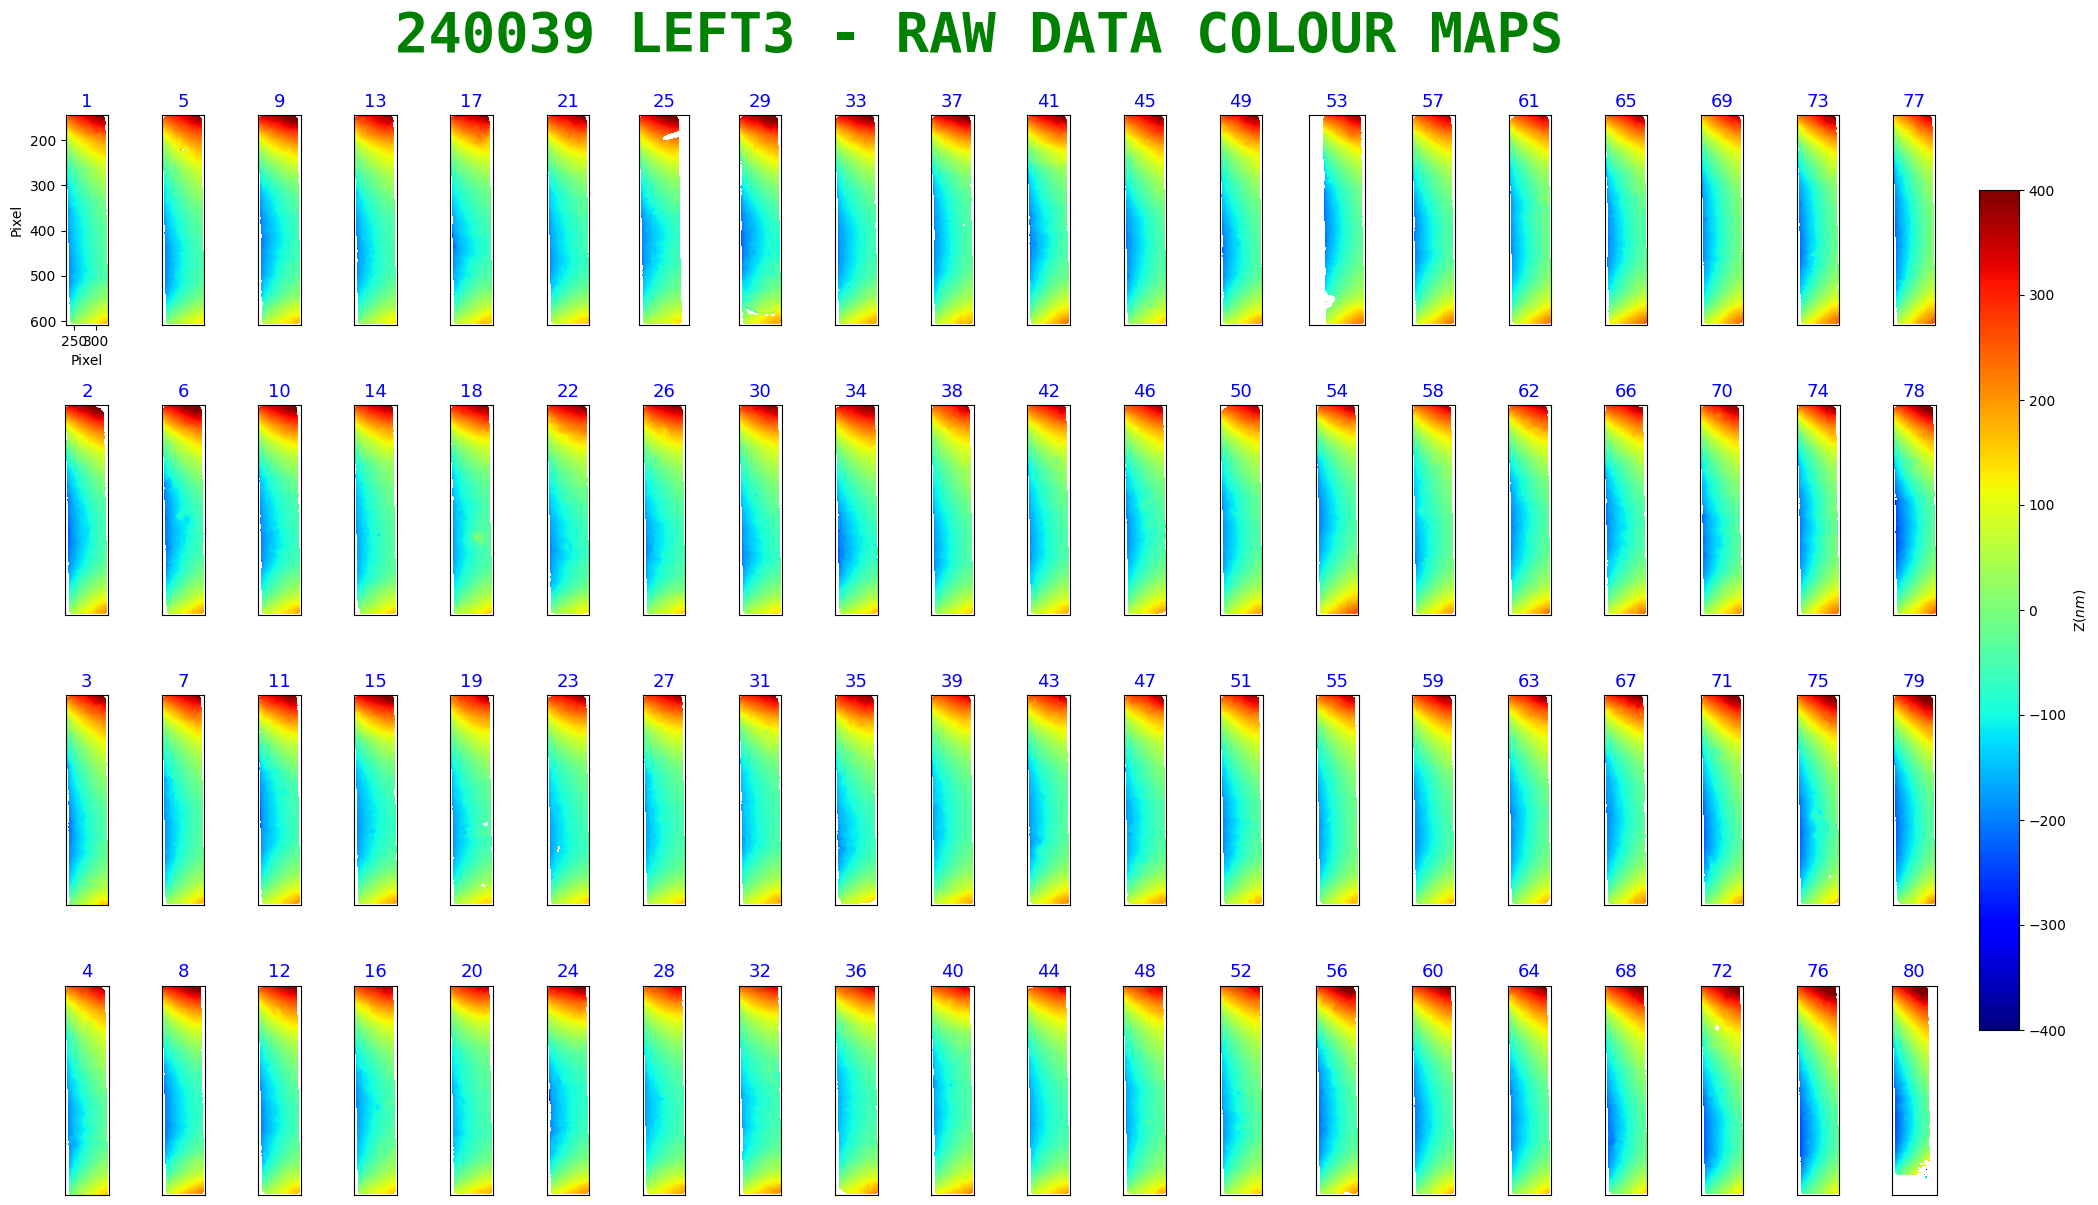

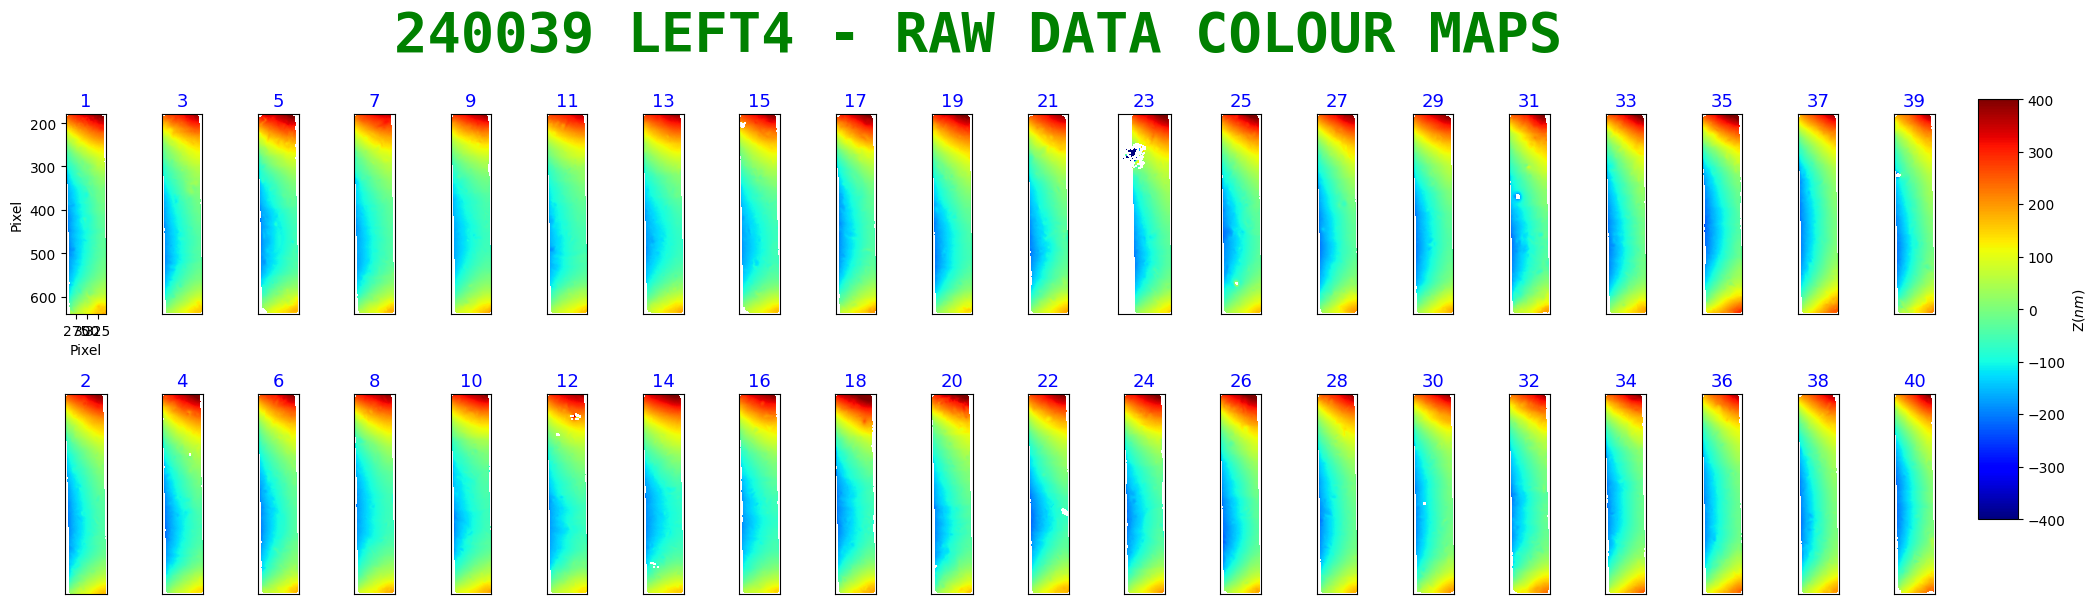

In [35]:
# --------------------------- RAW Colour Map Plots --------------------------- #
def plot_raw_data(data_raw, waferID, cubeID, laserIDrange, output_path, campaign_name, rows, cols, zlim_colour, imgqual, laser_plotting_order):
    # Calculate the figure size dynamically based on the number of rows and columns
    fig_width = cols * 1  # Adjust the multiplier as needed
    fig_height = rows * 3 # Adjust the multiplier as needed

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    fig.suptitle(f"{waferID} {cubeID} - RAW DATA COLOUR MAPS", fontsize=40, 
                 fontfamily='monospace', fontweight='bold', color='g', y=1)
    
    for plot_index in range(len(laserIDrange)):
        row = plot_index // cols
        col = plot_index % cols
        ax = axes[row, col]
        
        if plot_index < len(data_raw):
            image = data_raw[plot_index]
            im = ax.imshow(image, cmap='jet', aspect='equal')
            
            # Set the title based on the laser plotting order
            laserIDind = laser_plotting_order[plot_index]
            ax.set_title(f"{laserIDind + 1}", fontsize=13, color='b')
            
            # Only add axis labels to the first subplot
            if plot_index == 0:
                ax.set_xlabel('Pixel')
                ax.set_ylabel('Pixel')
            else:
                ax.set_xticks([])
                ax.set_yticks([])
            
            im.set_clim([-zlim_colour, zlim_colour])
                        
            # Set xlims and ylims to exclude empty spaces
            non_nan_indices = np.argwhere(~np.isnan(image))
            y_min, x_min = non_nan_indices.min(axis=0)
            y_max, x_max = non_nan_indices.max(axis=0)
            ax.set_xlim(x_min, x_max)
            ax.set_ylim(y_max, y_min)  # Note: y-axis is inverted in images
        else:
            ax.axis('off')
            
    # Add a single color bar on the side
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Z$(nm)$', fontsize=10)
    
    plt.tight_layout()
    output_file = os.path.join(output_path, f"{campaign_name}_{waferID}_{cubeID}_f1_Raw_Data.png")
    plt.savefig(output_file, dpi=imgqual, bbox_inches='tight')

# Plot raw data for each dataset
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    laserIDrange = laserIDranges[dataind]
    
    if DYNAMIC_ARRAYS:
        rows = ROW_DYNAMIC[dataind]
        cols = COLUMN_DYNAMIC[dataind]
    else:
        rows = ROWS
        cols = COLS
    
    plot_raw_data(data_raw[dataind], waferID, cubeID, laserIDrange, OUTPUTPATH, CAMPAIGN_NAME, rows, cols, ZLIM, IMGQUAL, laser_plotting_order[dataind])

# data_ind = 0
# plot_raw_data(data_raw[dataind], waferID, cubeID, laserIDrange, OUTPUTPATH, CAMPAIGN_NAME, rows, cols, ZLIM, IMGQUAL, laser_plotting_order[dataind])


C:\Users\762093\AppData\Local\Temp\1\ipykernel_11528\979316467.py:71: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


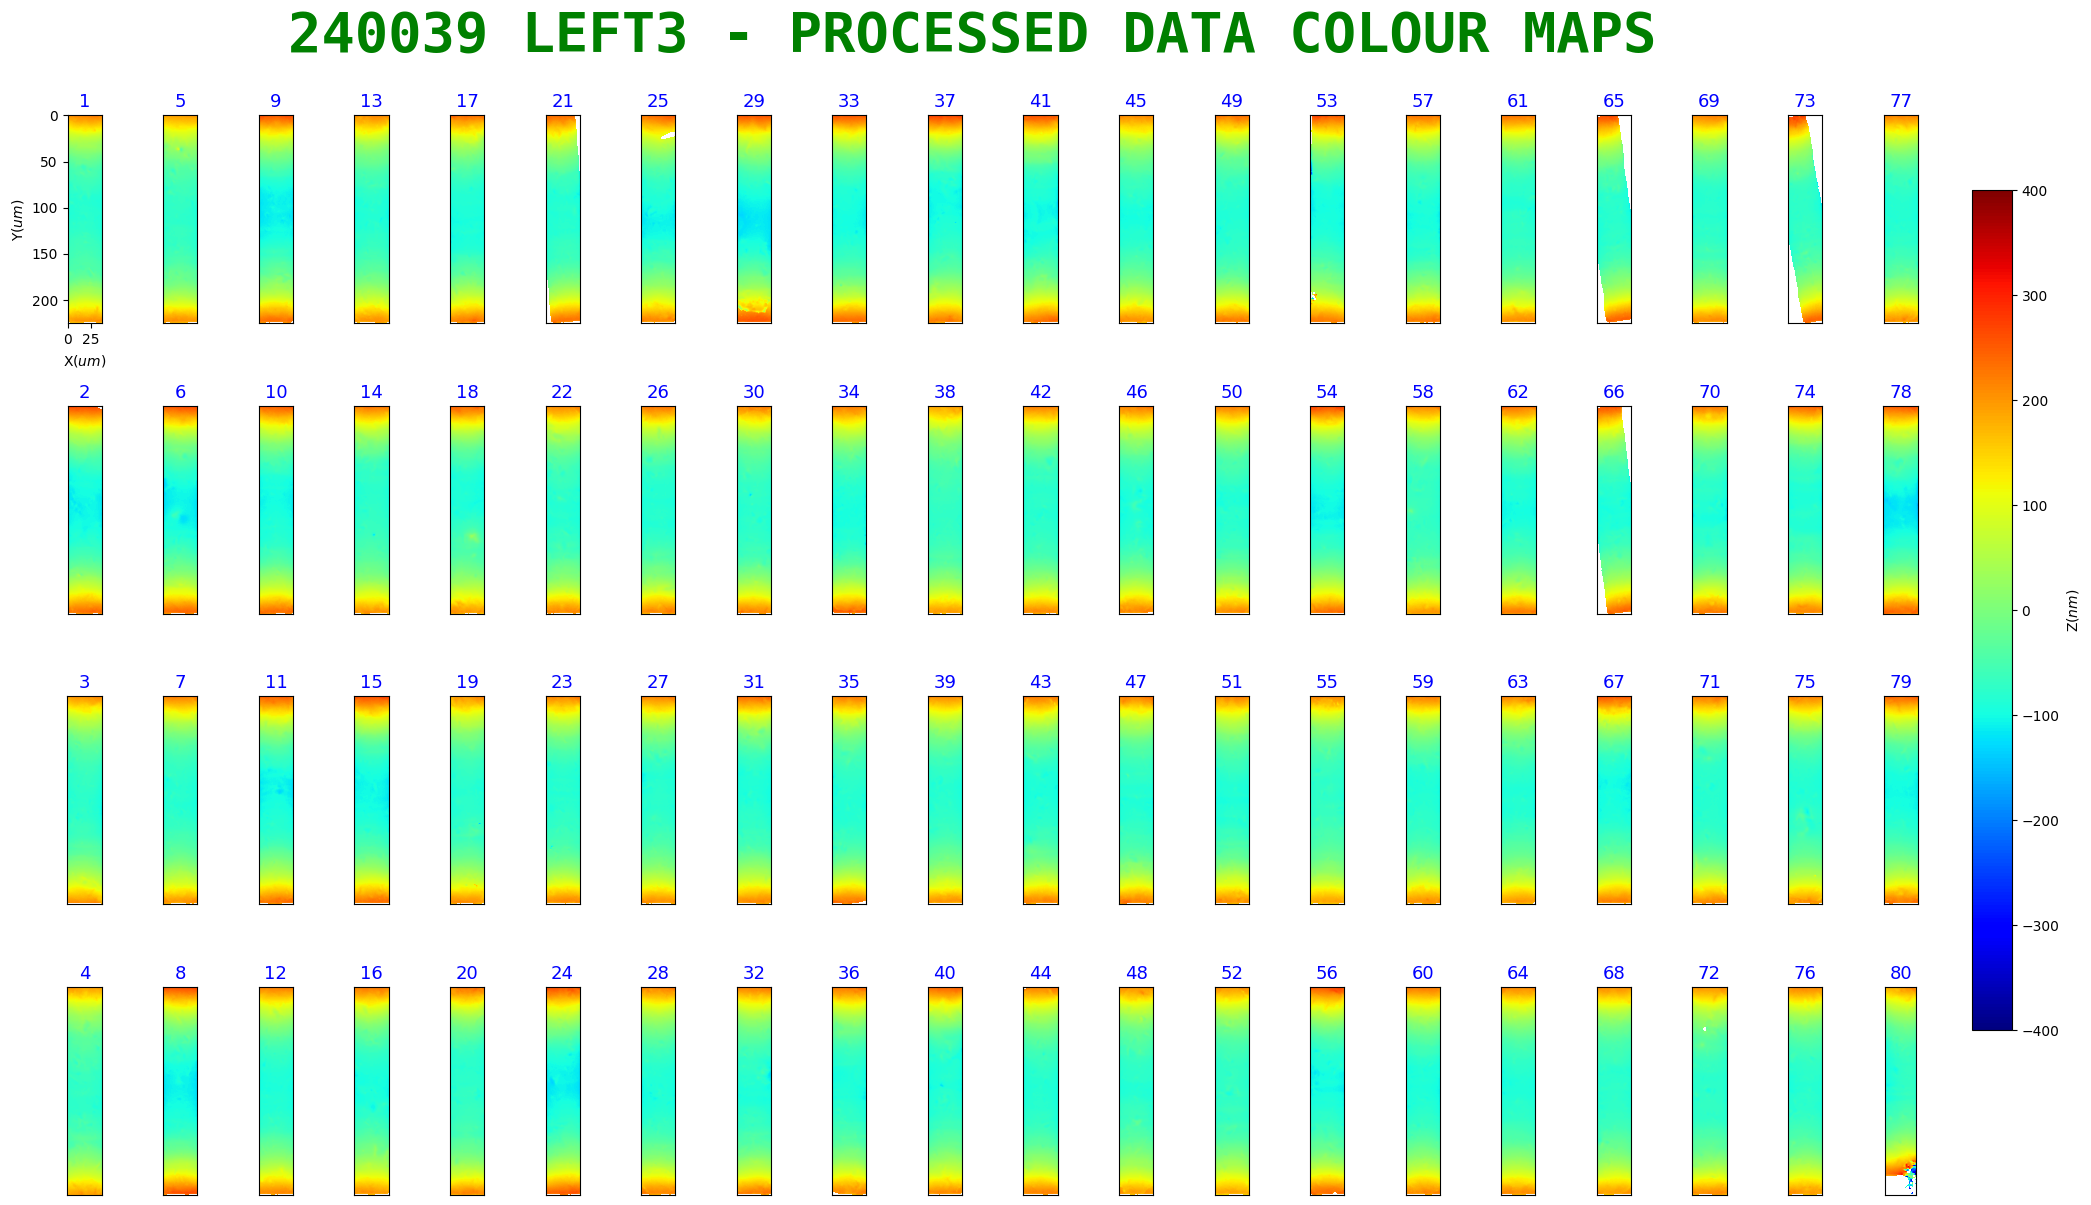

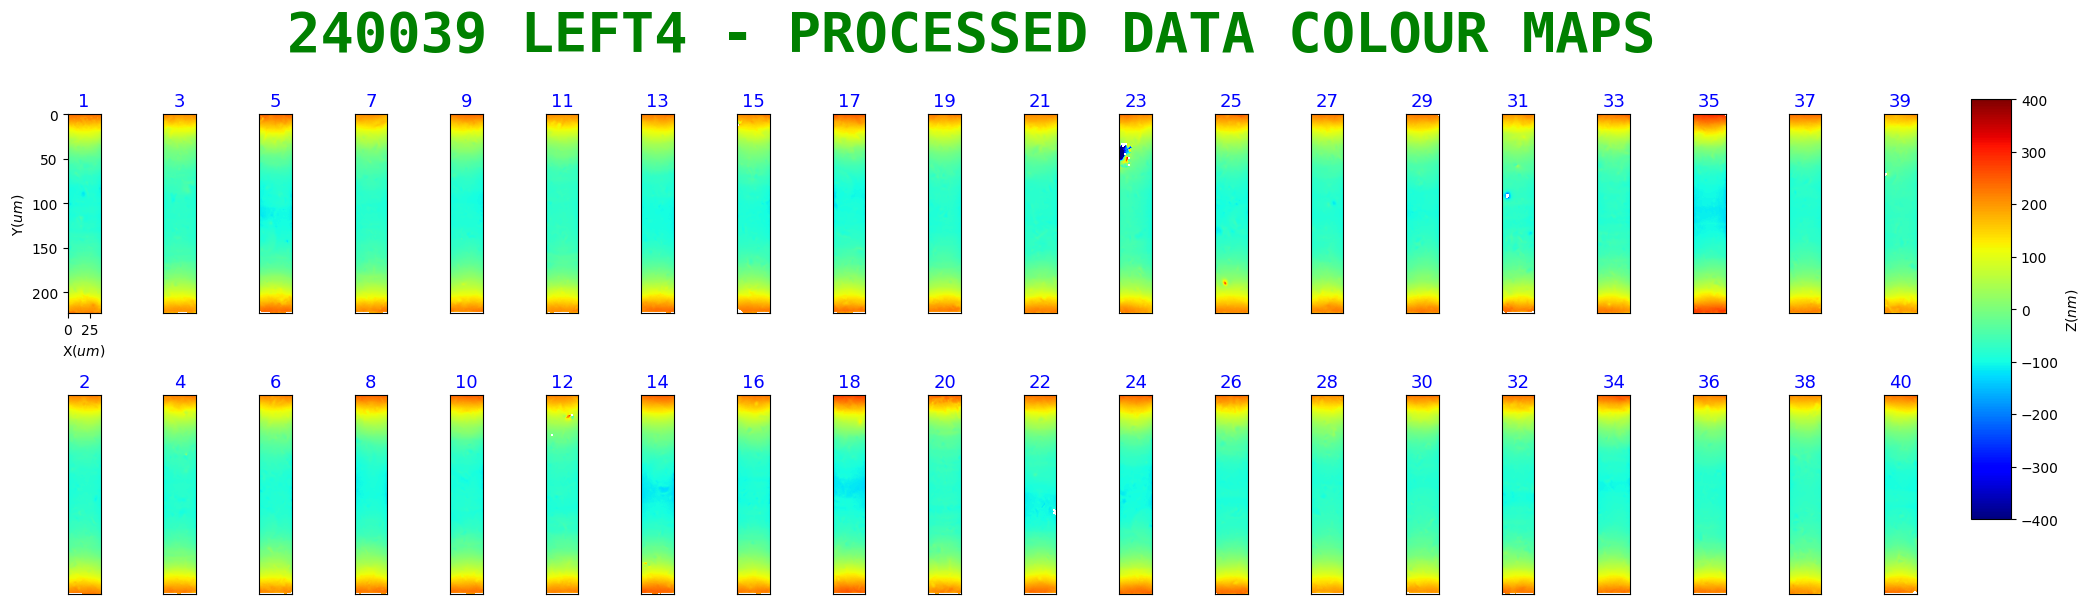

In [36]:
# --------------------------- PROCESSED Colour Map Plots --------------------------- #
# Function to transform data_processed into a format similar to image_raw
# Function to transform data_processed into a format similar to image_raw
def transform_processed_data_to_image(data_processed, resolution):
    x_min, x_max = np.min(data_processed[:, 0]), np.max(data_processed[:, 0])
    y_min, y_max = np.min(data_processed[:, 1]), np.max(data_processed[:, 1])
    
    x_size = int((x_max - x_min) / resolution) + 1
    y_size = int((y_max - y_min) / resolution) + 1
    
    transformed_data = np.full((x_size, y_size), np.nan)
    for point in data_processed:
        x, y, z = point
        x_idx = int((x - x_min) / resolution)
        y_idx = int((y - y_min) / resolution)
        if 0 <= x_idx < x_size and 0 <= y_idx < y_size:
            transformed_data[x_idx, y_idx] = z
    return transformed_data.T

# --------------------------- PROCESSED Colour Map Plots --------------------------- #
def plot_processed_data(data_processed, waferID, cubeID, laserIDrange, output_path, campaign_name, rows, cols, zlim_colour, imgqual, laser_plotting_order, resolution):
    # Calculate the figure size dynamically based on the number of rows and columns
    fig_width = cols * 1  # Adjust the multiplier as needed
    fig_height = rows * 3  # Adjust the multiplier as needed

    fig, axes = plt.subplots(rows, cols, figsize=(fig_width, fig_height))
    fig.suptitle(f"{waferID} {cubeID} - PROCESSED DATA COLOUR MAPS", fontsize=40, 
                 fontfamily='monospace', fontweight='bold', color='g', y=1)
    
    for plot_index in range(len(laserIDrange)):
        row = plot_index // cols
        col = plot_index % cols
        ax = axes[row, col]
        
        if plot_index < len(data_processed):
            image = transform_processed_data_to_image(data_processed[plot_index], resolution=resolution)  # Transform processed data to image format
            im = ax.imshow(image, cmap='jet', aspect='equal')  # Use the Z values for processed data
            
            # Set the title based on the laser plotting order
            laserIDind = laser_plotting_order[plot_index]
            ax.set_title(f"{laserIDind + 1}", fontsize=13, color='b')
            
            # Only add axis labels to the first subplot
            if plot_index == 0:
                ax.set_xlabel('X$(um)$')
                ax.set_ylabel('Y$(um)$')
            else:
                ax.set_xticks([])
                ax.set_yticks([])
            
            im.set_clim([-zlim_colour, zlim_colour])
                        
            # Set xlims and ylims to exclude empty spaces
            non_nan_indices = np.argwhere(~np.isnan(image))
            if non_nan_indices.size > 0:
                y_min, x_min = non_nan_indices.min(axis=0)
                y_max, x_max = non_nan_indices.max(axis=0)
                ax.set_xlim(x_min, x_max)
                ax.set_ylim(y_max, y_min)  # Note: y-axis is inverted in images
            else:
                ax.set_xlim(0, image.shape[1])
                ax.set_ylim(0, image.shape[0])
        else:
            ax.axis('off')
            
    # Add a single color bar on the side
    cbar_ax = fig.add_axes([1, 0.15, 0.02, 0.7])  # Adjust the position and size as needed
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Z$(nm)$', fontsize=10)
    
    plt.tight_layout()
    output_file = os.path.join(output_path, f"{campaign_name}_{waferID}_{cubeID}_f2_Processed_Data.png")
    plt.savefig(output_file, dpi=imgqual, bbox_inches='tight')

# Example usage
# Assuming data_processed is a list of arrays, each with shape (n, 3)
# Assuming laser_plotting_order is a list of lists, each with the order of lasers for each dataset

# Plot processed data for each dataset
for dataind, dataset in enumerate(DATASETS):
    waferID, cubeID = dataset.split('_CUBE_')
    laserIDrange = laserIDranges[dataind]
    
    if DYNAMIC_ARRAYS:
        rows = ROW_DYNAMIC[dataind]
        cols = COLUMN_DYNAMIC[dataind]
    else:
        rows = ROWS
        cols = COLS
    
    plot_processed_data(data_processed[dataind], waferID, cubeID, laserIDrange, OUTPUTPATH, CAMPAIGN_NAME, rows, cols, ZLIM, IMGQUAL, laser_plotting_order[dataind], resolution=1.0)